### A Simple Portfolio Allocation Problem

This example develops a very simple portfolio allocation problem. Real world portfolio allocation is complex!  A good exercise is reviewing this model (after we build it) and testing your modeling skills:  What aspects of the problem are not being modeled?  Are we modeling all the important aspects?  How much do you trust the solutions?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

### Loading Data

I did the work of reading in the data for you so that you guys can focus on modeling.  Please read the code below and try to understand what it's doing. Ask questions!

In [2]:
#read monthly_ret_simple.csv using numpy, but ignore the first row and ignore first column
monthly_returns = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', skip_header=True)[:,1:]  

#read in just the first row of monthly_ret_simple.csv, ignore first column and label as tickers
tickers = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', max_rows=1, dtype=str) [1:]

#read in just the first column of monthly_ret_simple.csv, ignoring the first row and label as dates
dates = np.genfromtxt('monthly_ret_simple.csv', delimiter=',', skip_header=True, usecols=0, dtype=str)

#convert monthly_returns into a dictionary where
# the keys are pairs of (date, ticker) and values are the return
monthly_returns_dict = { (dates[i], tickers[j]) : monthly_returns[i,j] for i in range(len(dates)) for j in range(len(tickers)) }



"tickers", "dates" and "monthly_returns_dict" are goign to be our data in this problem. You'll only need to access those three from now on.
Test you understand what's going on by printing out these items below (and make sure they look as you expect) and then compute a new dictionary called "average_returns" which has the average of the monthly returns for each asset.

In [3]:
#for each ticker in tickers, compute the average return and store in a dictionary
average_returns_dict = {ticker : np.mean(monthly_returns[:,i]) for i, ticker in enumerate(tickers)}

## On to the Actual Modeling!

In [4]:
#create a gurobi model
m = Model('portfolio')
target_return = 0.01

#create a continuous, nonegative variable for each asset in tickers
x = m.addVars(tickers, lb=0, vtype=GRB.CONTINUOUS)

#create continuous, unbounded variable each month called dev
dev = m.addVars(dates, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS)

#add a constraint that the sum over i in tickers of x[i] = 1
m.addConstr(quicksum(x[ticker] for ticker in tickers) == 1)

for date in dates:
    #  add a constraint that
    # dev[date] >= Sum over i in tickers of x[i] * monthly_returns_dict[date, i] - x[i] * average_return[i] 
    m.addConstr(dev[date] >= quicksum(x[ticker] * monthly_returns_dict[date, ticker] - x[ticker] * average_returns_dict[ticker] for ticker in tickers))

    #  add a constraint that
    # dev[date] >= Sum over i in tickers of x[i] * average_return[i] - x[i] * monthly_returns_dict[date, i]
    m.addConstr(dev[date] >= quicksum(x[ticker] * average_returns_dict[ticker] - x[ticker] * monthly_returns_dict[date, ticker] for ticker in tickers))


#add a constraint that 
#sum over i in tickers of the average_return[i] * x[i] >= target_return
m.addConstr(quicksum(average_returns_dict[ticker] * x[ticker] for ticker in tickers) >= target_return)

#set the objective to minimize the average of the deviations
m.setObjective(quicksum(dev[date] for date in dates) / len(dates), GRB.MINIMIZE)

m.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-03
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 48 columns and 1240 nonzeros
Model fingerprint: 0xbbff3a5a
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [4e-02, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 26 rows and 0 columns
Presolve time: 0.02s
Presolved: 28 rows, 48 columns, 642 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -4.8671570e-17   2.523803e+01   0.000000e+00      0s
      47    2.5246742e-02   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.03 seconds (0.00 work units)
Optimal objective  2.524674240e-02


In [5]:
#print the objective value
print('Objective:', m.objVal)

#print the x values in the optimal solution
for i in tickers:
    print(i, x[i].x)

Objective: 0.025246742402637218
AAPL 0.0
ARKK 0.0
BABA 0.0
BITO 0.0
EEM 0.0
EWJ 0.11389650400139079
FSLR 0.01907441352094636
GLD 0.5732914505908836
GRN 0.040709411816226074
HASI 0.0
ICLN 0.0
LIT 0.0
MSFT 0.0
NVDA 0.018355538454220326
PLD 0.0
SWBI 0.0
TSLA 0.0
TSM 0.0
USO 0.13684995435592698
VNO 0.0
VOO 0.0
XOM 0.09782272726040585


### Pushing yourself:  What happens if you ask for a target return of 10%?

Does this make sense?  what's the largest target return you can ask for?  You can either reason about this, or modify our optimization problem to compute it!  

<font color=blue>  You could just reason about this.  Since we can't short-sell, the portfolio return is like a weighted average of hte individual asset returns.  Since the average can't be more than the maximum, the best the portfolio can possibly do is the same as the best asset.  Based on that logic, we can compute it as follows: </font> 

In [6]:
#compute the maximum of the average_returns_dict
max_return = max(average_returns_dict.values())
max_return

0.039998657444333036

<font color=blue> Alternatively, we can just write an optimization problem to compute the maximal return!  Here we just use the same optimziation from before, but chaage our objective function!  Notice the optimal value matches above. </font> 

In [7]:
## modified optimization problem  to figure out maximal possible value
#Same as previous but change the objective value

#set the objective to be the sum over tickers of x[ticker] * average_returns_dict[ticker]
m.setObjective(quicksum(x[ticker] * average_returns_dict[ticker] for ticker in tickers), GRB.MAXIMIZE)

m.optimize()

#print the objective value
print('Objective:', m.objVal)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 48 columns and 1240 nonzeros
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [3e-04, 4e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
LP warm-start: use basis

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2500000e+28   5.291381e+30   1.000000e+00      0s
      17    3.9998657e-02   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.999865744e-02
Objective: 0.039998657444333036


# Pareto Curve

We'd like to construct a plot that shows us for each value of the target_return, what's the minimal risk possible.  We're going to do this by solving our optimization problem many times.  In class, I just did this a for loop.  But a more elegant solution is to define a function, which is what I do below.  

In [17]:
def compute_minimal_risk(target_return):
    #create a gurobi model
    m = Model('portfolio')

    #create a continuous, nonnegative variable for each asset in tickers
    x = m.addVars(tickers, lb=0, vtype=GRB.CONTINUOUS)

    #create continuous, nonnegative variable each month called dev
    dev = m.addVars(dates, lb=0, vtype=GRB.CONTINUOUS)

    #add a constraint that the sum of the x's must be at most 1
    m.addConstr(quicksum(x[i] for i in tickers) == 1)

    #for every date in dates,
    #add two constraints:
    #  Sum over tickers of x[ticker] * return[date,ticker] - x[ticker] * average_return[ticker] <= dev[date]
    #  Sum over tickers of x[ticker] * return[date,ticker] - x[ticker] * average_return[ticker] >= -dev[date]
    for date in dates:
        m.addConstr(quicksum(x[ticker] * monthly_returns_dict[date, ticker] - x[ticker] * average_returns_dict[ticker] for ticker in tickers) <= dev[date])
        m.addConstr(quicksum(x[ticker] * monthly_returns_dict[date, ticker] - x[ticker] * average_returns_dict[ticker] for ticker in tickers) >= -dev[date])

    #add a constraint that the sum over tickers of the average_return[ticker] * x[ticker] >= target_return
    m.addConstr(quicksum(average_returns_dict[ticker] * x[ticker] for ticker in tickers) >= target_return, name='target')

    #set the objective to minimize the sum of the deviations
    m.setObjective(quicksum(dev[date] for date in dates for ticker in tickers), GRB.MINIMIZE)

    m.optimize()

    #check the model status and throw an error if it's not optimal
    assert m.status == GRB.OPTIMAL, "Model is probably infeasible"

    #return the objective value
    return m.objVal, m



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 48 columns and 1240 nonzeros
Model fingerprint: 0xbbcd9cbc
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 54 rows, 48 columns, 1240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.782515e+00   0.000000e+00      0s
      53    1.4097810e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.409780989e+01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logica

Text(0, 0.5, 'Optimal Risk')

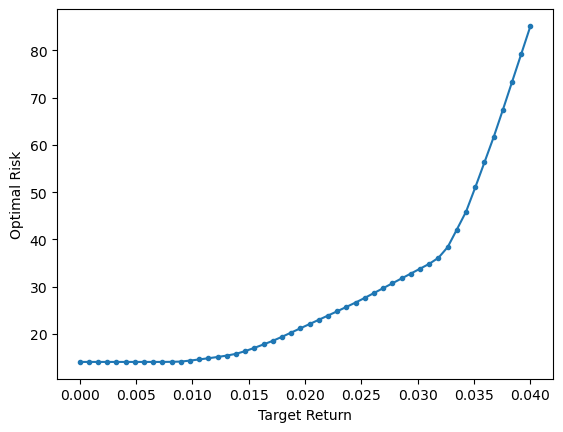

In [18]:
#create a grid of target returns from 0 to max_return with 50 points
target_returns = np.linspace(0, max_return, 50)

#initialize a list to store the optimal objective values
optimal_risks = []

#loop over the target returns and compute the optimal objective value for each
for target_return in target_returns:
    optimal_risks.append(compute_minimal_risk(target_return)[0])

#plot the optimal risks on the y-axis and the target returns on the x-axis
plt.plot(target_returns, optimal_risks, marker=".")
plt.xlabel('Target Return')
plt.ylabel('Optimal Risk')

## Connection to Sensitivity Analysis

The curve above looks piecewise linear.  We want to understand the slopes of each piece and the breakpoints.  

To start us thinking, let's solve the model again at target_return = .025 and look at teh sensitivity table.

In [19]:
optimal_risk, m = compute_minimal_risk(.025)

import buad313_tools
buad313_tools.sensitivity_analysis(m)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 48 columns and 1240 nonzeros
Model fingerprint: 0x7a5b50ce
Coefficient statistics:
  Matrix range     [5e-05, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+00]
Presolve time: 0.01s
Presolved: 54 rows, 48 columns, 1240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.055121e+00   0.000000e+00      0s
      35    2.7264659e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.03 seconds (0.00 work units)
Optimal objective  2.726465913e+01
Variable Cells
     Final Value  Reduced Cost  Objective Coefficient  Allowable Increase  Allowable Decrease
C0    0.00000000   15.67040261             0.00000000                 